<a href="https://colab.research.google.com/github/faysalislam/12misha/blob/master/own.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!wget https://s3.us-east-2.amazonaws.com/naturalimages02/images.tar.gz

--2019-09-18 04:33:40--  https://s3.us-east-2.amazonaws.com/naturalimages02/images.tar.gz
Resolving s3.us-east-2.amazonaws.com (s3.us-east-2.amazonaws.com)... 52.219.100.202
Connecting to s3.us-east-2.amazonaws.com (s3.us-east-2.amazonaws.com)|52.219.100.202|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 176799632 (169M) [application/x-gzip]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 168.61M  22.5MB/s    in 8.1s    

2019-09-18 04:33:54 (20.9 MB/s) - ‘images.tar.gz’ saved [176799632/176799632]



In [0]:
!tar -xzf images.tar.gz

In [0]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
train_path = 'images/train/'
test_path = 'images/test/'
batch_size = 16
image_size = 224
num_class = 8

In [0]:
train_datagen = ImageDataGenerator(validation_split=0.3,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

In [0]:
train_generator = train_datagen.flow_from_directory(
                        directory=train_path,
                        target_size=(image_size,image_size),
                        batch_size=batch_size,
                        class_mode='categorical',
                        color_mode='rgb',
                        shuffle=True)

Found 6899 images belonging to 8 classes.


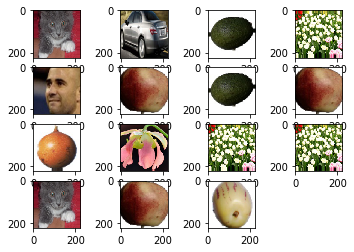

In [0]:
x_batch, y_batch = train_generator.next()

fig=plt.figure()
columns = 4
rows = 4
for i in range(1, columns*rows):
    num = np.random.randint(batch_size)
    image = x_batch[num].astype(np.int)
    fig.add_subplot(rows, columns, i)
    plt.imshow(image)
plt.show()

In [0]:
import keras
from keras.models import Model, load_model
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

In [0]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))





58892288/58889256 [==============================] - 1s 0us/step




In [0]:
print(base_model.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
for layer in base_model.layers:
    layer.trainable = False

In [0]:
model = keras.models.Sequential()

In [0]:
model.add(base_model)

In [0]:
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(num_class, activation='softmax'))

In [0]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 8200      
Total params: 41,463,624
Trainable params: 26,748,936
Non-trainable params: 14,714,688
_________________________________________________________________
None


In [22]:
ls

data.csv  fine_tune.h5  images/  images.tar.gz  sample_data/


In [0]:
from keras.optimizers import SGD

In [0]:
model.compile(loss='categorical_crossentropy',
          optimizer=SGD(lr=1e-3),
          metrics=['accuracy'])

In [20]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.n/batch_size,
        epochs=10)
        
model.save('fine_tune.h5')

Epoch 1/10


KeyboardInterrupt: ignored

In [0]:
model = load_model('fine_tune.h5')

Found 6899 images belonging to 8 classes.
Found 14 images belonging to 8 classes.


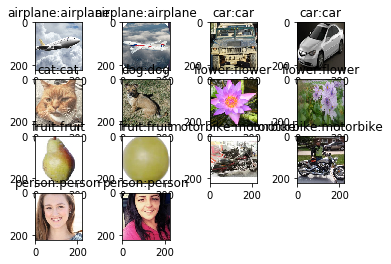

In [25]:
test_datagen = ImageDataGenerator()
train_generator = train_datagen.flow_from_directory(
                        directory=train_path,
                        target_size=(image_size,image_size),
                        batch_size=batch_size,
                        class_mode='categorical',
                        color_mode='rgb',
                        shuffle=True)

test_generator = test_datagen.flow_from_directory(
                        directory=test_path, 
                        target_size=(image_size, image_size),
                        color_mode='rgb',
                        shuffle=False,
                        class_mode='categorical',
                        batch_size=1)

filenames = test_generator.filenames
nb_samples = len(filenames)

fig=plt.figure()
columns = 4
rows = 4
for i in range(1, columns*rows -1):
    x_batch, y_batch = test_generator.next()

    name = model.predict(x_batch)
    name = np.argmax(name, axis=-1)
    true_name = y_batch
    true_name = np.argmax(true_name, axis=-1)

    label_map = (test_generator.class_indices)
    label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
    predictions = [label_map[k] for k in name]
    true_value = [label_map[k] for k in true_name]

    image = x_batch[0].astype(np.int)
    fig.add_subplot(rows, columns, i)
    plt.title(str(predictions[0]) + ':' + str(true_value[0]))
    plt.imshow(image)
plt.show()